# Modelo Holt-Winters


&nbsp;&nbsp;&nbsp;&nbsp;O modelo Holt-Winters, também conhecido como suavização exponencial tripla, é utilizado principalmente para prever séries temporais que apresentam tanto uma tendência (um aumento ou diminuição constante ao longo do tempo) quanto sazonalidade (padrões que se repetem periodicamente, como ciclos mensais ou anuais). Ele trabalha separando a série em três componentes principais: o nível, que é o valor médio da série no tempo atual; a tendência, que capta a direção geral dos dados; e a sazonalidade, que lida com os padrões cíclicos recorrentes.

&nbsp;&nbsp;&nbsp;&nbsp;Uma vantagem do Holt-Winters é que ele pode ser ajustado automaticamente usando coeficientes de suavização, que controlam o quanto o modelo deve responder a mudanças nos dados para cada um desses componentes. Existem duas variações principais do modelo: o aditivo, que assume que a sazonalidade tem um impacto constante ao longo do tempo; e o multiplicativo, que ajusta a sazonalidade de forma proporcional ao nível da série, ou seja, o efeito sazonal cresce conforme a série aumenta.

&nbsp;&nbsp;&nbsp;&nbsp;O Holt-Winters é ideal para séries temporais que seguem padrões bem definidos ao longo do tempo, como dados de vendas mensais ou anuais, sem a necessidade de uma grande quantidade de dados ou de ajuste intensivo de parâmetros. Por isso, ele é especialmente útil em cenários em que a simplicidade e a capacidade de capturar tendência e sazonalidade são cruciais.

&nbsp;&nbsp;&nbsp;&nbsp;Por outro lado, se compararmos o Holt-Winters com modelos como Random Forest ou XGBoost, as diferenças ficam claras. Random Forest é um modelo baseado em árvores de decisão que trabalha bem com grandes conjuntos de dados e pode lidar com relações complexas entre variáveis. Ele funciona criando várias árvores de decisão em subconjuntos de dados e depois faz uma média das previsões dessas árvores, o que ajuda a reduzir o risco de overfitting. No entanto, ele não lida diretamente com séries temporais, ou seja, não capta tendências ou sazonalidades automaticamente. Para usar o Random Forest em séries temporais, você precisa primeiro transformar a série em variáveis que o modelo possa entender, como criar novas colunas a partir das datas (por exemplo, usando o mês ou o ano como variáveis).

&nbsp;&nbsp;&nbsp;&nbsp;Já o XGBoost é um modelo de aprendizado supervisionado baseado em boosting, onde múltiplos modelos fracos (como árvores de decisão) são combinados para melhorar a precisão. Cada novo modelo criado corrige os erros dos modelos anteriores, e isso faz com que o XGBoost seja altamente eficiente para dados tabulares, particularmente em competições de machine learning. Assim como o Random Forest, ele não capta automaticamente a estrutura temporal dos dados. Para usar o XGBoost com séries temporais, você precisa fazer uma engenharia de features, criando variáveis baseadas no tempo e em outros fatores para alimentar o modelo.

## Importando as bibliotecas que iremos usar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import gdown
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import itertools
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

##Importando a base de dados já tratada

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


## Uso do gdown

Utilizamos a biblioteca `gdown` para facilitar o download de arquivos diretamente do Google Drive. Abaixo está um resumo do uso do `gdown`:

1. **Importação do gdown**:
    ```python
    import gdown
    ```

2. **Definição do ID do arquivo e URL**:
    - `file_id`: '1BeB7U-Y-wN5L5XnSw-QIpph4MXd93g0V'
    - `url`: 'https://drive.google.com/uc?id=1BeB7U-Y-wN5L5XnSw-QIpph4MXd93g0V'

3. **Download do arquivo**:
    Utilizamos o `gdown.download` para baixar o arquivo CSV do Google Drive e salvá-lo localmente com o nome `dataframe_alterado.csv`.
    ```python
    gdown.download(url, 'dataframe_alterado.csv', quiet=False)
    ```

Este processo automatiza a obtenção dos dados necessários para a análise, garantindo que todos os colaboradores do projeto possam acessar o mesmo conjunto de dados de forma simples e eficiente.


In [ ]:
#  baixando o gdown para baixar o arquivo

!pip install gdown

In [ ]:
# Colocar o ID do arquivo aqui (substitua 'FILE_ID' pelo ID correto)
file_id = '1BeB7U-Y-wN5L5XnSw-QIpph4MXd93g0V'
url = f'https://drive.google.com/uc?id={file_id}'

# - https://drive.google.com/file/d/1BeB7U-Y-wN5L5XnSw-QIpph4MXd93g0V/view?usp=sharing

# Baixar o arquivo
gdown.download(url, 'dataframe_alterado.csv',quiet=False)

In [4]:
df = pd.read_csv('dataframe_alterado.csv')

In [5]:
df.head()

,Unnamed: 0,year,month,Setor,Origem,Veiculo,Vl Liquido Final,"PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1) (%)"
0,0,2020,1,2,1,13,908.16,1.8
1,1,2020,1,2,5,4,200.00,1.8
2,2,2020,1,2,5,6,293.56,1.8
3,3,2020,1,2,5,7,286.12,1.8
4,4,2020,1,2,5,8,241.44,1.8


In [6]:
label_encoder = LabelEncoder() # Instanciando o LabelEncoder


df['Setor'] = label_encoder.fit_transform(df['Setor'])
df['Veiculo'] = label_encoder.fit_transform(df['Veiculo'])
df['Origem'] = label_encoder.fit_transform(df['Origem'])

In [7]:
# Definindo o índice com 'Ano' e 'Mês'
df.set_index(['year', 'month'], inplace=True)

# Visualizando o resultado
df.head()


Unnamed: 0  Setor  Origem  Veiculo  Vl Liquido Final  \
year month                                                         
2020 1               0      2       1       13            908.16   
     1               1      2       5        4            200.00   
     1               2      2       5        6            293.56   
     1               3      2       5        7            286.12   
     1               4      2       5        8            241.44   

            PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1) (%)  
year month                                                                                 
2020 1                                                    1.8                              
     1                                                    1.8                              
     1                                                    1.8                              
     1                                                    1.8                              
     1                                                    1.8

In [8]:
df_2020 = df.loc[2020]
df_2021 = df.loc[2021]
df_2022 = df.loc[2022]
df_2023 = df.loc[2023]

In [9]:
df_2020 .head(10)

,Unnamed: 0,Setor,Origem,Veiculo,Vl Liquido Final,"PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1) (%)"
month,,,,,,
1,0,2,1,13,908.16,1.8
1,1,2,5,4,200.00,1.8
1,2,2,5,6,293.56,1.8
1,3,2,5,7,286.12,1.8
1,4,2,5,8,241.44,1.8
1,5,2,5,14,2235.75,1.8
1,6,2,5,15,2384.25,1.8
1,7,6,0,4,1600.00,1.8
1,8,6,0,8,2305.12,1.8


In [10]:
# Agrupar por 'Ano', 'Mês', 'UEN', e 'Veiculo', somando os valores de 'VL Liquido Final'
df_grouped = df.groupby(['year', 'month', 'Veiculo', 'Setor', 'Origem'])['Vl Liquido Final'].sum().reset_index()

# Exibir as primeiras linhas do DataFrame agrupado
df_grouped.shape


(17597, 6)

In [11]:
df_grouped

,year,month,Veiculo,Setor,Origem,Vl Liquido Final
0,2020,1,0,6,5,2240.00
1,2020,1,0,8,5,3102.95
2,2020,1,0,12,5,29028.14
3,2020,1,0,15,5,14211.34
4,2020,1,0,17,5,8710.03
...,...,...,...,...,...,...
17592,2024,4,18,43,0,200.00
17593,2024,4,18,51,0,200.00
17594,2024,4,18,54,0,102025.00
17595,2024,4,18,63,0,11250.00


In [12]:
df = df_grouped

display(df)

,year,month,Veiculo,Setor,Origem,Vl Liquido Final
0,2020,1,0,6,5,2240.00
1,2020,1,0,8,5,3102.95
2,2020,1,0,12,5,29028.14
3,2020,1,0,15,5,14211.34
4,2020,1,0,17,5,8710.03
...,...,...,...,...,...,...
17592,2024,4,18,43,0,200.00
17593,2024,4,18,51,0,200.00
17594,2024,4,18,54,0,102025.00
17595,2024,4,18,63,0,11250.00


In [13]:
df_grouped['Vl Liquido Final'].mean()

22533.308382110587

In [14]:
import pandas as pd

# Definir a coluna de data com Ano e Mês
df['Data'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))

# Definir a coluna 'Data' como índice para a série temporal
df.set_index('Data', inplace=True)

# Agregar os valores de receita por mês (ou já usar diretamente se a agregação já foi feita)
serie_temporal = df['Vl Liquido Final'].resample('M').sum()

# Verificar a frequência dos dados
freq = pd.infer_freq(serie_temporal.index)
if freq is None:
    freq = 'MS'  # Assumir frequência mensal
    print("Warning: Data frequency could not be inferred. Assuming 'MS' (month start).")

# Visualizar a série temporal
print(serie_temporal.head())


Data
2020-01-31    5393691.53
2020-02-29    5751548.26
2020-03-31    5894599.74
2020-04-30    3923482.31
2020-05-31    3993915.02
Freq: M, Name: Vl Liquido Final, dtype: float64


In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ajustar o modelo Holt-Winters
modelo_hw = ExponentialSmoothing(serie_temporal,
                                 trend='add',       # ou 'mul' para tendência multiplicativa
                                 seasonal='add',    # ou 'mul' para sazonalidade multiplicativa
                                 seasonal_periods=12)  # Sazonalidade anual, 12 meses

# Treinar o modelo
ajuste_hw = modelo_hw.fit()

# Fazer previsões para os próximos 12 meses (ou qualquer número que você escolher)
previsao = ajuste_hw.forecast(12)

# Visualizar a previsão
print(previsao)


2024-05-31    8.032000e+06
2024-06-30    1.011019e+07
2024-07-31    7.955046e+06
2024-08-31    8.939323e+06
2024-09-30    8.539298e+06
2024-10-31    9.039944e+06
2024-11-30    1.012482e+07
2024-12-31    1.297985e+07
2025-01-31    7.790966e+06
2025-02-28    7.257719e+06
2025-03-31    8.416447e+06
2025-04-30    8.629557e+06
Freq: M, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [18]:
# Suprimir avisos de convergência para manter o código limpo
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Dividindo os dados em treino (80%) e teste (20%)
tamanho_treino = int(len(serie_temporal) * 0.8)
dados_treino = serie_temporal.iloc[:tamanho_treino]
dados_teste = serie_temporal.iloc[tamanho_treino:]

# Log para o início do ajuste do modelo Holt-Winters
logger.info("Ajustando o modelo Holt-Winters com dados de treino")

# Ajustar o modelo com os dados de treino
modelo_hw_treino = ExponentialSmoothing(dados_treino,
                                        trend='add',
                                        seasonal='add',
                                        seasonal_periods=12).fit()

# Log de sucesso do ajuste do modelo
logger.info("Modelo ajustado com sucesso.")

# Verificar se os parâmetros existem e logar
params = modelo_hw_treino.model.params
alpha = params.get('smoothing_level', 'N/A')
beta = params.get('smoothing_slope', 'N/A')  # Pode não existir se a otimização falhar
gamma = params.get('smoothing_seasonal', 'N/A')

logger.info(f"Parâmetros ajustados: Alpha (nível) = {alpha}, Beta (tendência) = {beta}, Gamma (sazonalidade) = {gamma}")

# Fazer previsões para o período de teste
logger.info("Fazendo previsões para o período de teste")
previsoes_teste = modelo_hw_treino.forecast(len(dados_teste))

# Log das previsões feitas
logger.info("Previsões realizadas para o período de teste")

# Avaliar o modelo com métricas como MAE e MSE
mae = mean_absolute_error(dados_teste, previsoes_teste)
mse = mean_squared_error(dados_teste, previsoes_teste)

# Log das métricas de avaliação
logger.info(f"MAE: {mae}")
logger.info(f"MSE: {mse}")

# Se quiser, também pode logar os valores reais e previstos para inspeção
logger.debug(f"Valores reais: {dados_teste.values}")
logger.debug(f"Previsões: {previsoes_teste.values}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [21]:
# Importar as bibliotecas necessárias
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import logging

# Configurar o logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

# Verificar se há valores nulos ou infinitos em dados_teste ou previsoes_teste
if dados_teste.isnull().any() or np.isinf(dados_teste).any():
    logger.warning("Existem valores nulos ou infinitos em dados_teste!")
if previsoes_teste.isnull().any() or np.isinf(previsoes_teste).any():
    logger.warning("Existem valores nulos ou infinitos em previsoes_teste!")

# Calcular MSE
mse = mean_squared_error(dados_teste, previsoes_teste)
logger.info(f"MSE calculado: {mse}")

# Calcular MAE
mae = mean_absolute_error(dados_teste, previsoes_teste)
logger.info(f"MAE calculado: {mae}")

# Calcular R²
r2 = r2_score(dados_teste, previsoes_teste)
logger.info(f"R² calculado: {r2}")

# Calcular RMSE
rmse = np.sqrt(mse)
logger.info(f"RMSE calculado: {rmse}")

# Calcular MAPE (com verificação para evitar divisão por zero)
mape = np.mean(np.abs((dados_teste - previsoes_teste) / dados_teste.replace(0, np.nan))) * 100
logger.info(f"MAPE calculado: {mape}%")

# Exibir as métricas
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")


MSE: 3829565466660.169
MAE: 1644965.833235552
R²: -0.02810487110132187
RMSE: 1956927.5578467816
MAPE: 20.202074834155262%


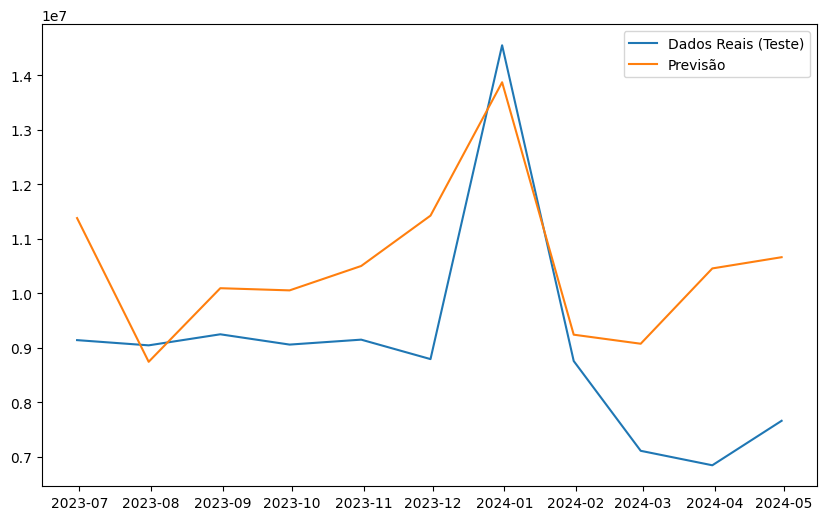

In [20]:
import matplotlib.pyplot as plt

# Plotar os dados de treino, teste e previsão
plt.figure(figsize=(10, 6))
plt.plot(dados_teste.index, dados_teste, label='Dados Reais (Teste)')
plt.plot(dados_teste.index, previsoes_teste, label='Previsão')
plt.legend()
plt.show()
